# AIMS CDT: Machine Learning Assignment
Implementation of a neural network "from scratch".

### Import the required libraries

In [73]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random, math


### Import the MNIST dataset

Display a few random items

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train
Number of images: 10
Image pixel size: 784 




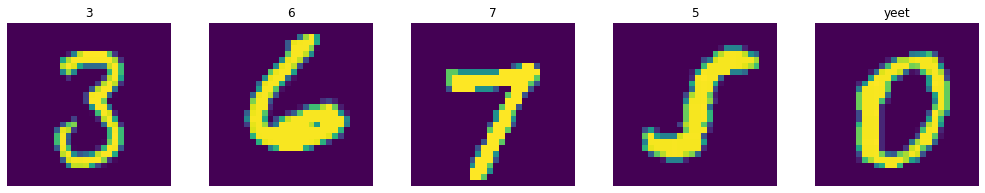

In [27]:
import random

class Dataset(object):
    
    def __init__(self, dataset, N):

        # Create matrix where columns are images
        self.features = torch.zeros(28*28, N)
        self.classes = torch.zeros(N, dtype=torch.int8)
        self.targets = torch.zeros(10, N, dtype=torch.int8)
        
        # Randomly sample N items from the full dataset
        for i, j in enumerate(random.sample(list(range(len(dataset.data))), N)):

            d = dataset.data[j]

            # Flattened image and class
            img = d.view(-1, 28*28)
            target = dataset[j][1]
            # print(target, img)

            self.features[:, i] = img / 255.0
            self.classes[i] = target
            self.targets[target, i] = 1

            if i == N-1:
                break

    def __len__(self):
        return len(self.targets)


# Load the dataset
# transform=transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.1307,), (0.3081,))
#     ])
mnist = datasets.MNIST('../data', train=True, download=True)
                    # transform=transform)

print(mnist)

N = 10
data = Dataset(mnist, N)

# Print data stats
print('Number of images:', len(data))
print('Image pixel size:', data.features.shape[0], '\n\n')

# def display_sample(i):
#     '''
#     Display an image sampled from the MNIST dataset.
#     '''
#     plt.axis('off')
#     plt.title(int(data.classes[i]))
#     plt.imshow(data.features[:, i].view(28,28)) # un-flatten
#     plt.show()

# Display a random sample of images
N = len(data)
k = 5
samples = random.sample(range(N), k=k)

fig, ax = plt.subplots(1, k, figsize=(3.5*k, 3))
for i, j in enumerate(samples):

    ax[i].axis('off')
    ax[i].set_title(int(data.classes[j]))
    ax[i].imshow(data.features[:, j].view(28,28)) # un-flatten

plt.show()



In [18]:

class Activation(object):

    def __init__(self, f='relu'):

        if f == 'sigmoid':
            self.func = self.sigmoid

        elif f == 'relu':
            self.func = self.relu

        # Default value
        else:
            self.func = self.relu

    def __call__(self, x):
        return self.func(x) 

    def sigmoid(self, x): 
        return 1/(1+torch.exp(-x))

    def relu(self, x): 
        return torch.clamp(x,0)

class Loss(object):

    def __init__(self, f='crossentropy'):
        if f == 'crossentropy':
            self.func = self.cross_entropy

        # Default value
        else:
            self.func = self.cross_entropy

    def cross_entropy(self, y_pred, y_true):
        '''
        Cross entropy for prediction probabilities x
        and true classes y.
        '''
        # loss = - torch.sum(y_true * torch.logsoftmax(y_pred, 0))
        N = y_pred.shape[1]
        loss = - torch.sum(y_true * torch.log2(torch.softmax(y_pred, 0))) / N
        # loss = torch.sum((y_true - y_pred)**2)
        # print(y_pred)

        # loss = torch.zeros(1,1)
        # for i in range(len(y_true)):
        #     loss -= torch.log2(y_pred[y_true[i], i])
            # print(y_true[i])

        return loss


    def __call__(self, y_pred, y_true):
        return self.func(y_pred, y_true)



class NeuralNetwork(object):

    def __init__(self, layers, iter=100, learning_rate=1e-4, activation='sigmoid'):

        # TODO: add bias term
        self.layers = []
        self.weights = []
        self.biases = []
        self.rate = learning_rate
        self.iter = iter

        self.create_network(layers)


        self.activation = Activation('sigmoid')

    def create_network(self, layers):

        # Create layers
        for L in layers:
            self.layers.append(torch.zeros(L, 1))

        # Create weights
        for i in range(len(layers) - 1):
            # Li is nx1, Lj is mx1 where j=i+1
            # wij is m x n 
            n, m = layers[i], layers[i+1]
            
            # Weight matrices
            # Initialised by sampling from standard normal
            # Require gradients to be computed for autograd
            self.weights.append(torch.randn(m, n, requires_grad=True))
            self.biases.append(torch.randn(1, 1, requires_grad=True))

    def forward(self, sig):
        '''
        Propagate signal forward through network.
        '''
        out = sig

        for i in range(len(self.weights)):
            out =  self.weights[i] @ out + self.biases[i]
            if i < len(self.weights) - 1:
                out = self.activation(out)

        return out

    def predict(self, out):
        return torch.argmax(out, 0)

    # def run_iteration(self, x):

        

    # def train(self):

    #     for i in range(self.iter):
    #         self.run_iteration()



In [94]:
# Load sample from dataset for training
N_train = 8192
mnist_train = datasets.MNIST('../data', train=True, download=True)
data_train = Dataset(mnist_train, N_train)

# Test data
N_test = 1024
mnist_test = datasets.MNIST('../data', train=False, download=True)
data_test = Dataset(mnist_test, N_test)


layers = [784, 128, 64, 10]
nn = NeuralNetwork(layers, 
    activation='relu')

x_train = data_train.features
y_train = data_train.classes

x_test = data_test.features
y_test = data_test.classes

iter = 400
learning_rate = 1
batch_size = 64
num_batches = math.ceil(N_train / batch_size)

compute_loss = Loss('crossentropy')

loss_history = []
training_history = []
test_history = []


for i in range(iter):

    # Run each mini batch
    for b in range(num_batches):

        i1 = b * batch_size
        i2 = min(i1 + batch_size, N_train)

        y_pred = nn.forward(x_train[:, i1:i2])
        y_true = data_train.targets[:, i1:i2]
        # print(y_pred[:,0])

        # Compute loss
        loss = compute_loss(y_pred, y_true)
        loss_history.append(loss.item())

        # Backward pass
        loss.backward()

        # Apply backward update
        with torch.no_grad():
            for j in reversed(range(len(nn.weights))):
                
                # Update weights (incl. biases) via gradient descent
                nn.weights[j].sub_(learning_rate * nn.weights[j].grad)
                nn.biases[j].sub_(learning_rate * nn.biases[j].grad)

                # Reset stored gradients
                nn.weights[j].grad.data.zero_()
                nn.biases[j].grad.data.zero_()
        # print('-------------- Finished batch ' + str(b))

    # print('\npred:', pred)
    # print('true:', data_train.classes)

    # Compute accuracy on training set
    # if i % 20 == 0:
    #     out = nn.forward(x_train)
    #     y_pred = nn.predict(out)
        
    #     correct = torch.sum(y_pred == y_train).item()
    #     acc = float(correct) / len(y_pred) * 100
    #     print('Iteration {:4d} - training accuracy {:.2f}%'.format(i, acc))
        # training_history.append(acc)

    # Compute accuracy on test set
    if i % 20 == 0:
        out = nn.forward(x_test)
        y_pred = nn.predict(out)
        
        correct = torch.sum(y_pred == y_test).item()
        acc = float(correct) / len(y_pred) * 100
        print('Iteration {:4d} - test accuracy {:.2f}%'.format(i, acc))
        test_history.append(acc)


print('\n\nTraining completed')




Iteration    0 - test accuracy 58.89%
Iteration   20 - test accuracy 87.40%
Iteration   40 - test accuracy 87.89%
Iteration   60 - test accuracy 88.67%
Iteration   80 - test accuracy 88.96%
Iteration  100 - test accuracy 88.57%
Iteration  120 - test accuracy 88.48%
Iteration  140 - test accuracy 88.77%
Iteration  160 - test accuracy 88.77%
Iteration  180 - test accuracy 88.77%
Iteration  200 - test accuracy 88.87%
Iteration  220 - test accuracy 88.77%
Iteration  240 - test accuracy 88.77%
Iteration  260 - test accuracy 88.77%


KeyboardInterrupt: 

### Plotting output

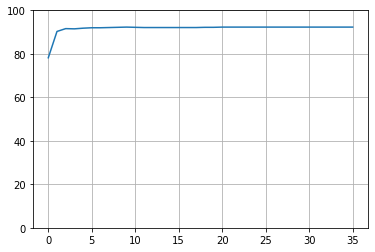

In [89]:
plt.grid()
plt.ylim([0, 100])
plt.plot(test_history)
plt.show()




tensor([8.0713e-04, 1.9951e-05, 8.0299e-01, 1.6551e-01, 2.5149e-03, 3.6162e-03,
        1.5254e-04, 1.0285e-06, 2.2722e-02, 1.6715e-03],
       grad_fn=<SelectBackward>)
tensor([9.9988e-01, 2.4357e-08, 8.9272e-05, 8.3607e-07, 3.1745e-08, 2.1801e-05,
        5.9189e-07, 1.2213e-07, 2.7922e-06, 2.9933e-09],
       grad_fn=<SelectBackward>)
tensor([6.8070e-06, 3.5338e-06, 7.6484e-06, 2.4688e-05, 9.6004e-03, 3.0987e-05,
        1.2776e-05, 7.5619e-04, 1.6580e-06, 9.8956e-01],
       grad_fn=<SelectBackward>)


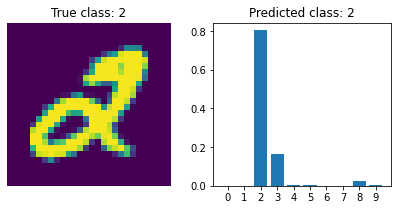

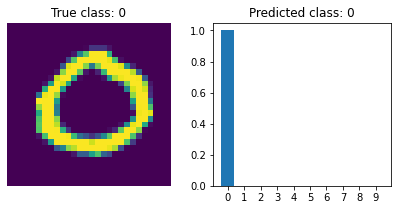

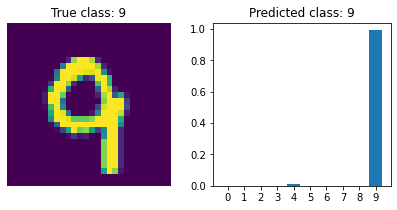

In [71]:

# Sample a few test data items for plotting
k = 3
data_display = Dataset(mnist_test, k)

x_display = data_display.features
out = nn.forward(x_display)
y_pred = torch.softmax(out, 0)


for i in range(k):
    fig, ax = plt.subplots(1, 2, figsize=(7, 3))

    ax[0].axis('off')
    ax[0].set_title('True class: ' + str(int(data_display.classes[i])))
    ax[0].imshow(data_display.features[:, i].view(28,28)) # un-flatten

    
    print(y_pred[:,i])
    ax[1].bar(range(10), y_pred[:,i].detach().numpy())
    pred = torch.argmax(y_pred[:,i]).item()
    ax[1].set_title('Predicted class: ' + str(pred))
    plt.xticks(range(10))


plt.show()